### Data Preprocessing using FunctionTransformers, ColumnTransformers and Pipeline

* After inferring required preprocessing steps in `"dataExploration.ipnyb"` script, preprocessing is implemented in this script.
* Used ***FunctionTransformer*** to convert custom functions into Transformers
* Used ***ColumnTransformer*** to perform multiple transforming steps on different columns of dataset.
* Created ***Pipeline*** to merge all the preprocessing steps and to reuse this pipeline in predictions

**Predict whether a person has autism or not; using other dependent variables (Features)**


* `ID` - ID of the patient
* `A1_Score to A10_Score` - Score based on Autism Spectrum Quotient (AQ) 10 item screening tool
* `age` - Age of the patient in years
* `gender` - Gender of the patient
* `ethnicity` - Ethnicity of the patient
* `jaundice` - Whether the patient had jaundice at the time of birth
* `autism` - Whether an immediate family member has been diagnosed with autism
* `contry_of_res` - Country of residence of the patient
* `used_app_before` - Whether the patient has undergone a screening test before
* `result` - Score for AQ1-10 screening test
* `age_desc` - Age of the patient
* `relation` - Relation of patient who completed the test
* `Class/ASD` - Classified result as 0 or 1. Here 0 represents No and 1 represents Yes. This is the target column

In [1]:
#Imported required libraries
try:
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os
    from sklearn.compose import ColumnTransformer
    from sklearn.preprocessing import FunctionTransformer,MinMaxScaler, OneHotEncoder
    from sklearn.pipeline import Pipeline
    import pickle

except ModuleNotFoundError as err:
    print('Package/Module not found in dataPreprocess.py file' )

In [2]:
# Function to load dataset into dataframe

def load_data(filename):
    
    
    try:
        #full_path = os.path.join(path, filename)
        return pd.read_csv(filename)
    
    except FileNotFoundError as err:
        print('Input data file is not found in dataExploration.py file')
        print(err)
        
    except:
        print('Isse when loading input CSV data in dataExploration.py file')      


df_train = load_data('train.csv')

In [3]:
df_train.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,austim,contry_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1
3,4,0,0,0,0,0,0,0,0,0,...,f,?,no,no,United States,no,2.276617,18 and more,Self,0
4,5,0,0,0,0,0,0,0,0,0,...,m,?,no,no,South Africa,no,-4.777286,18 and more,Self,0


In [4]:
# 'age_desc' column has only one value - ['18 and more']
# 'ID' column has all unique values and acting like an index. Hence, it can be removed

df_train.drop(['ID','age_desc'], axis=1, inplace= True)

### Spliting features and labels

In [5]:
target = df_train.pop('Class/ASD')
df_train.shape, target.shape

((800, 19), (800,))

### Design of pre-processing steps

* Created 3 FunctionTransfomers from custom function for following preprocessing steps:
        1) Handle outliers 2) Handle unkown/missing values 3) Handle rare occurring countries

* Created 2 ColumnTransformers to implement following preprocessing steps
        1) ColumnTransformer-1 = To include above mentioned 3 FunctionTransformers
        2) ColumnTransformer-2 = To implement OneHotEncoding and Scaling
        
* Create 1 Piepline to merge above mentioned two ColumnTransformers

### Handling Outliers for continuous columns

Two continuous columns in the data - *Age Column* & *Result Column*

In [6]:
class OutliersHandling:
    
    def calculate_tail(self, col):
        
        ''' 
        Considering a value as outlier if it is lower than lower_tail and greater than upper tail. 
        Therefore, this function calculated lower and upper tail of given column

        '''
        try:
            q1 = col.quantile(0.25) #Lower Quartile
            q3 = col.quantile(0.75) #Upper Quartile
            iqr = q3 - q1                          #Calculating Inter Quartile Range (IQR)
            upper_tail = q3 + 1.5 * iqr
            lower_tail = q1 - 1.5 * iqr
            return float(upper_tail), float(lower_tail)
        
        except Exception as err:
            print('Issue in Calculate_tail function of OutliersHandling class')
            print(err)

    def check_outliers(self,col):
        ''' Check total number of outliers in given continuous column'''
        try:
            n = 0
            upper_tail, lower_tail = self.calculate_tail(col)

            # Considering a value as outlier if it is lower than lower_tail and greater than upper tail
            for val in col:
                if val > upper_tail or val < lower_tail:
                       n = n+1

            print(f'Total number of outliers in the {col.name} column: ',n)
        
        except Exception as err:
            print('Issue in check_outliers function of OutliersHandling class')
            print(err)

        
    def handle_outliers(self, df):
        ''' Replacing lower outliers with 10th percentile and upper outliers with 90th percentile '''
        try:
            for x in df.columns:

                upper_tail, lower_tail = self.calculate_tail(df[x]) #Calling function to calculate lower and upper tail

                for i in df[x].values:
                    if i > upper_tail or i < lower_tail:
                        if i < lower_tail:
                            df[x].replace(i,df[x].quantile(0.10), inplace= True)
                        else:
                            df[x].replace(i,df[x].quantile(0.90), inplace= True)
            return df

        except Exception as err:
            print('Issue in Calculate_tail function of OutliersHandling class')
            print(err)

outhandle_obj = OutliersHandling() # Creating Object of the class


***Checking Outliers***

Total number of outliers in the age column:  35


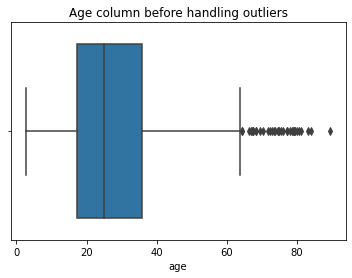

In [7]:
outhandle_obj.check_outliers(df_train['age'])

# Creating boxplot for visualization
sns.boxplot(x= 'age', data= df_train)
plt.title(f'Age column before handling outliers')
plt.show()

Total number of outliers in the result column:  1


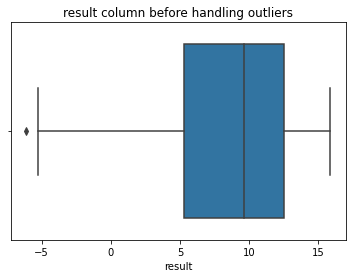

In [8]:
outhandle_obj.check_outliers(df_train['result'])

# Creating boxplot for visualization
sns.boxplot(x= 'result', data= df_train)
plt.title(f'result column before handling outliers')
plt.show()

### Handling Missing/unkown Values

Two columns has unkown values - *ethnicity* & *relation*

In [9]:
df_train['ethnicity'].value_counts()

White-European     257
?                  203
Middle Eastern      97
Asian               67
Black               47
South Asian         34
Pasifika            32
Others              29
Latino              17
Hispanic             9
Turkish              5
others               3
Name: ethnicity, dtype: int64

In [10]:
df_train['relation'].value_counts()

Self                        709
?                            40
Parent                       29
Relative                     18
Others                        2
Health care professional      2
Name: relation, dtype: int64

**⬆️ Ethnicity and relation columns has '?' and 'others' values which seems to be unkown**

#### Transformation on country_of_res column

In [11]:
df_train['contry_of_res'].value_counts()

United States           134
India                   108
New Zealand              78
United Kingdom           67
Jordan                   55
United Arab Emirates     40
Australia                37
Canada                   30
Afghanistan              22
Netherlands              20
Austria                  18
Sri Lanka                17
Brazil                   12
Spain                    10
France                   10
Kazakhstan               10
Ireland                   9
Iran                      8
Russia                    7
South Africa              6
Italy                     6
Bahamas                   6
Malaysia                  6
Viet Nam                  5
Pakistan                  4
China                     4
Mexico                    4
Nicaragua                 4
Armenia                   4
Azerbaijan                4
Iraq                      4
Aruba                     4
Saudi Arabia              4
AmericanSamoa             4
Bolivia                   3
Serbia              

Merging coutnries which are occurring less then 6 times into 'Other' category.

In [12]:
occ = df_train['contry_of_res'].value_counts()

rare_country = [con for con in occ.index if occ[con]<6]
print(rare_country)

['Viet Nam', 'Pakistan', 'China', 'Mexico', 'Nicaragua', 'Armenia', 'Azerbaijan', 'Iraq', 'Aruba', 'Saudi Arabia', 'AmericanSamoa', 'Bolivia', 'Serbia', 'Ethiopia', 'Iceland', 'Germany', 'Ukraine', 'Niger', 'Cyprus', 'Sweden', 'Oman', 'Belgium', 'Romania', 'Burundi', 'Czech Republic', 'Egypt', 'Angola', 'Sierra Leone', 'Japan', 'Argentina', 'Tonga', 'Hong Kong', 'Bangladesh']


In [13]:
class MissingValHandling:
    
    def handle_missing_values(self, df):
        '''Replacing ("?" and "others") -> "Others" '''
        try:
            for col in df.columns:
                df[col].replace(['?','others'],['Others','Others'], inplace= True)
            return df
        
        except Exception as err:
            print('Issue in handle_missing_values function of MissingValHandling Class ')
            print(err)

    def merging_rare_counties(self, df):
        ''' 
        This function is specially for "Country_of_res" column.
        Some countries are occuring less than 6 times and converting all of them into one category "Others"
        '''
        try:
            for col in df.columns:
                df[col].replace(rare_country, 'Others', inplace= True)
            return df
        
        except Exception as err:
            print('Issue in merging_rare_counties function of MissingValHandling Class ')
            print(err)


missval_obj = MissingValHandling()

In [14]:
# This configuration is necessary to plot design of pipeline while fitting Pipeline 
from sklearn import set_config

set_config(display='diagram')

#### Column Transformer 1

In [15]:
'''
* Created ColumnTransformer consisting 3 FunctionTransformers. 
* These FunctionTransformers are converting Custom Function into Transformers

* FunctionTransformer-1 = It is handling outliers of two continuous columns - (age and reult) using 
    handle_outliers() function of OutliersHandling Class

* FunctionTransformer-2 = It is handling Missing values of two categorical columns - (ethnicity and relation) using
    handle_missing_values function of MissingValHandling Class

* FunctionTransformer-3 = It is converting rare countries into 'Other' category - using 
    merging_rare_counties function of MissingValHandling Class
'''
try:
    col_trans_1 = ColumnTransformer([
        ('outlier', FunctionTransformer(func=outhandle_obj.handle_outliers),['age','result']),
        ('miss_val', FunctionTransformer(func=missval_obj.handle_missing_values),['ethnicity','relation']),
        ('rare_contry', FunctionTransformer(func=missval_obj.merging_rare_counties),['contry_of_res']),

    ], remainder= 'passthrough')
    
except ModuleNotFoundError as err:
    print('FunctionTransformer or ColumnTransformer are not found')
except Exception as err:
    print('Issue while building ColumnTransformer-1')
    print(err)

#### Column Transformer 2

In [16]:
'''
* Created ColumnTransformer consisting 2 Transformers

* MinMaxScaler = Scaling values of two continuous columns -(age and result)

* OneHotEncoder = Applying encoding on remaining categorical columns

'''

try:
    col_trans_2 = ColumnTransformer([
        ('scaler',MinMaxScaler(),[0,1]),
        ('encoder', OneHotEncoder(handle_unknown = 'ignore', drop= 'first'), (slice(2,19))),

    ], remainder='passthrough')

except ModuleNotFoundError as err:
    print('FunctionTransformer or ColumnTransformer are not found')
except Exception as err:
    print('Issue while building ColumnTransformer-2')
    print(err)

#### Pipeline

In [17]:
'''
Created Pipeline that includes both ColumnTransformers constructed above. Pipeline consists all preprocessing steps
'''
try:
    pipe = Pipeline([
        ('col_trans_1', col_trans_1),
        ('col_trans_2', col_trans_2)
    ])

except ModuleNotFoundError as err:
    print('Pipeline not found')
except Exception as err:
    print('Issue while building Pipeline')
    print(err)

In [18]:
pipe.fit(df_train)

Pipeline(steps=[('col_trans_1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('outlier',
                                                  FunctionTransformer(func=<bound method OutliersHandling.handle_outliers of <__main__.OutliersHandling object at 0x000001D8BCF71220>>),
                                                  ['age', 'result']),
                                                 ('miss_val',
                                                  FunctionTransformer(func=<bound method MissingValHandling.handle_missing_values of <__main__.Missin...
                                                 ('rare_contry',
                                                  FunctionTransformer(func=<bound method MissingValHandling.merging_rare_counties of <__main__.MissingValHandling object at 0x000001D8BD7B1C70>>),
                                                  ['contry_of_res'])])),
                ('col_trans_2',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  [0, 1]),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  slice(2, 19, None))]))])

In [19]:
# Transforming dataset using Pipeline and converting result into dataframe
try:
    df_new = pipe.transform(df_train)
    df_new = pd.DataFrame(df_new.toarray())
    df_new
except Exception as err:
    print('Issue will transforming training data using Pipeline')
    print(err)

In [20]:
#Pipeline generate feature names in interger format and integer naming of input is giving warning while Model trainig.
#Therefore, convert name of features from int to string

col_str_name = [str(col) for col in df_new.columns]
df_new.columns = col_str_name


### Save Pipeline and preprocessed data

In [21]:
'''
Saved new data into csv file after transforming data by appling preprocessing steps.
This csv will be use by "modelTraining.py" scirpt to feed input to ML model and train different models. 
'''
df_preprocessed = pd.concat([df_new,target],axis=1)

filename = 'preprocessed_data.csv'

df_preprocessed.to_csv(filename, index= False)

In [22]:
'''
Saved pipeline as pkl; so it can be re-used in "autism-app.py" script while making predciton for user input.
'''
filename = 'autism_pipeline.pkl'
pickle.dump(pipe, open(filename, 'wb'))
